# Benchmarking notebook

This notebook contains all of the methods and analysis for performing benchmarking.

Each section contains a description to allow for more-easily walking through the code. We keep the benchmarking code in a jupyter-notebook as we antipate ourselves (and others) adding new parsers and using this for replicating/extending benchmarking.

# Imports and dependencies

In [11]:
# std library
import os
import glob
from pathlib import Path
from enum import Enum
import numpy as np
from dataclasses import dataclass
from typing import List, Dict
import pickle
import json
# non-std library
import matplotlib.pyplot as plt

# Notebook parameters
These parameters are used throughout the notebook for benchmarking. These parameters include paths, tuning, and other various parameter settings.

In [12]:
file_with_names = "./abundance_new.tsv"
accession2taxid_file_path = "../../database/krakenDB/taxonomy/nucl_gb.accession2taxid"
ncbi_map_file_path = "ncbi_map.tab"

In [13]:
if not os.path.exists(ncbi_map_file_path):
    !cat ../../database/krakenDB/taxonomy/nucl_gb.accession2taxid | grep "NC_" > ncbi_map.tab

# Create mapping dictionary
This step is used for creating a map from NCBI IDs to taxonomy IDs.

In [15]:
def get_needed_ncbi_ids():
    """
    **DEPRECATED FUNCTION**
    was originally used to get NCBI ids from an output
    fastviromexplorer file.
    **DEPRECATED FUNCTION**
    """
    file_with_names_opened = open(file_with_names)
    
    # grab all needed NCBI ids
    ncbi_ids = []
    line = file_with_names_opened.readline()
    line_counter = 0
    while(line):
        if (line_counter > 0): # skip header
            ncbi_id = line.split("\t")[0]
            ncbi_ids.append(ncbi_id)
        line = file_with_names_opened.readline()
        line_counter += 1
        
    file_with_names_opened.close()
    
    return ncbi_ids

ncbi_ids = get_needed_ncbi_ids()

In [17]:
def create_mapping_dictionary(map_file=ncbi_map_file_path):
    """
    Creates dictionary for mapping NCBI ids to 
    taxonomy.
    -------------------------
    Notes:
        1. cat nucl_gb.accession2taxid | grep "NC_" > ncbi_ids.tab
        2. Uses ncbi_ids.tab
    -------------------------
    NC_033618	NC_033618.1	1931113	1139918407
    """
    # grab taxid mappings
    acc2tax_open = open(map_file)
    line = acc2tax_open.readline()
    counter = 0
    while(line):
        line = line.split("\t")
        accession = line[0]
        taxid = line[2]
        dictionary[accession] = taxid
        counter += 1
#         if (counter % 10000 == 0):
#             print(f"{counter} lines have been parsed \n")
        line = acc2tax_open.readline()
    acc2tax_open.close()
    
    return dictionary

dictionary = create_mapping_dictionary()

In [18]:
dictionary['NC_014459']

'2919554'

# Parsers
These methods are used for parsing all of the tools being benchmarked. These parsers are passed to a general parser function, giving a strategy-pattern-like method for obtaining result from tools.

In [118]:
def parser_enrichseq(enrichseq_dir: Path, delim=",", output_file='taxid_abundances.csv'):
    """
    Description
    -----------
        This function parses the enrichseq output directory.
        
    Note
    ----------
    use 'taxid_abundances.csv' or 'merge_overlap_out_refined.csv'
    Input
    -----------
        1. Path to a singular EnrichSeq output directory.
        2. [optional; Def=','] - delimiter
        
    Output
    -----------
        Abundance Dictionary containing:
            1. taxid abundances
            abundances_dict = {'tax_id_1' : 33,
                               'tax_id_2' : 33,
                               ...,
                               'tax_id_N' : 33,
                              }
            2. cluster abundances
            abundances_dict = {'cluster_1' : 33,
                               'cluster_2' : 33,
                               ...,
                               'cluster_M' : 33,
                              }
    """
    # nested dictionary of different abundance measurements
    abundances = {"taxid_abundance" : {},"cluster_abundance" : {}} 
    # get paths
    output_path1 = enrichseq_dir / Path('enrichseq/output_files/')
    output_path = enrichseq_dir / Path('enrichseq/output_files/')
    taxid_abundances_path = output_path / Path(output_file)
    
    cluster_abundances_path = output_path1 / Path('cluster_abundances.csv')
    csvs_to_parse = {"taxid_abundance" : taxid_abundances_path, 
                     "cluster_abundance" : cluster_abundances_path}
    # parse abundance CSVs
    for csv_name, csv_file in csvs_to_parse.items():
        with open(csv_file, "r") as csv_file_opened:
            csv_file_lines = csv_file_opened.readlines() # never that big, read all into RAM
            for line in csv_file_lines:
                tax_clust_id, abundance_val = line.strip("\n").split(delim)
                abundances[csv_name][tax_clust_id] = float(abundance_val)

    return abundances

def parser_fastviromeexplorer(directory, name_column=0, counts_column=3, delim="\t"):
    """                          
    Description
    -----------
        This function parses the FastViromeExplorer output directory.
        
    Input
    -----------
        1. Path to a singular FastViromeExplorer output directory.
        2. column index corresponding to NCBI id
        3. column index corresponding to the read counts
        4. [optional; Def='\t'] - delimiter
        
    Output
    -----------
        Abundance Dictionary containing:
            1. taxid abundances
            abundances_dict = {'tax_id_1' : 33,
                               'tax_id_2' : 33,
                               ...,
                               'tax_id_N' : 33,
                              }
    """
    # init datastructures
    abundances = {"taxid_abundance" : {}} # <tax/clust>id : abundance

    # read in the NCBI to Tax id namings
    with open('out_dictionary.txt') as f:
        dictionary_str = f.read()
    dictionary = json.loads(dictionary_str)
    dictionary.update(make_dir())
    dictionary.update(create_mapping_dictionary())
    # get paths
    taxid_abundances = directory / Path('abundance.tsv')
    # parse abundance CSVs
    csvs_to_parse = {"taxid_abundance" : taxid_abundances}
    total_abundance = 0
    for csv_name, csv_file in csvs_to_parse.items():
        with open(csv_file, "r") as csv_file_opened:
            csv_file_lines = csv_file_opened.readlines() # never that big, read all into RAM
            for line_ind, line in enumerate(csv_file_lines):
                if line_ind > 0: # skip header
                    ncbi_id = line.strip("\n").split(delim)[name_column]
                    counts_val = line.strip("\n").split(delim)[counts_column]

                    # convert NCBI name to taxid, save counts
                    if ncbi_id in dictionary:
                        tax_clust_id = dictionary[ncbi_id] # 'dictionary' imported above
                    elif ncbi_id.split(".")[0] in dictionary:
                        tax_clust_id = dictionary[ncbi_id.split(".")[0]] # 'dictionary' imported above
                    else:
                        tax_clust_id = 'unk'
                        if float(counts_val) > 0.01:
                            print(f"ERROR:")
                            print(f"\tFVE: {ncbi_id} NOT CONVERTED")
                            print(f"\tabundances: {float(counts_val)}")
                    abundances[csv_name][tax_clust_id] = float(counts_val)
                    total_abundance += float(counts_val)
    
    # update abundances dictionary
    ids_to_del = []
    for tax_id, abundance_val in abundances["taxid_abundance"].items():
        if total_abundance > 0:
            abundances["taxid_abundance"][tax_id] /= total_abundance #normalize
        if abundances["taxid_abundance"][tax_id] < 0.001:
            ids_to_del.append(tax_id)
    # delete 0 value taxids
    for val in ids_to_del:
        del abundances["taxid_abundance"][val]

    return abundances

def parser_bracken(directory, taxid_column=1, abundance_column=6, delim="\t"):
    """
    Description
    -----------
        This function parses the enrichseq output directory.
        
    Input
    -----------
        1. Path to a singular Bracken output directory.
        2. [optional; Def='\t'] - delimiter
        
    Output
    -----------
        Abundance Dictionary containing:
            1. taxid abundances
            abundances_dict = {'tax_id_1' : 33,
                               'tax_id_2' : 33,
                               ...,
                               'tax_id_N' : 33,
                              }
    """
    # dictionary of bracken abundance 
    abundances = {'taxid_abundance' : {}}
    # get paths
    taxid_abundances = directory / Path('abundances.bracken')
    dictionary = make_dir()
    files_to_parse = {"taxid_abundance" : taxid_abundances}
    
    # parse bracken abundance files
    for file_name, bracken_file in files_to_parse.items():
        with open(bracken_file, "r") as bracken_file_opened:
            bracken_file_lines = bracken_file_opened.readlines() # never that big, read all into RAM
            for line_ind, line in enumerate(bracken_file_lines):
                if line_ind > 0: # skip header
#                     ncbi_id = line.strip("\n").split(delim)[name_column]
#                     counts_val = line.strip("\n").split(delim)[counts_column]
                    tax_id = line.strip("\n").split(delim)[taxid_column]
                    abundance_val = line.strip("\n").split(delim)[abundance_column]
                    abundances[file_name][tax_id] = float(abundance_val)
    
    # update abundances dictionary
    ids_to_del = []
    for tax_id, abundance_val in abundances["taxid_abundance"].items():
        if abundances["taxid_abundance"][tax_id] < 0.001:
            ids_to_del.append(tax_id)
    # delete 0 value taxids
    for val in ids_to_del:
        del abundances["taxid_abundance"][val]

    return abundances

def make_dir():
    ncbi2taxid = "//scratch/summit/dral3008/BENCHMARKING_RESULTS/database/krakenDB/seqid2taxid.map"
    dictionary = {}
    with open(ncbi2taxid) as ncbi2taxid:
        lines = ncbi2taxid.readlines()
        for line in lines:
            ncbi, taxid = line.replace("\n","").split("\t")
            dictionary[ncbi] = taxid
    return dictionary

def parse_simulated_fasta(fasta_path):
    """                          
    Description
    -----------
        This function parses the simulated true fasta file used
        for testing.
        
    Input
    -----------
        1. Path to a singular simulated fasta file
        
    Output
    -----------
        Abundance Dictionary containing:
            1. taxid abundances
            abundances_dict = {'tax_id_1' : 33,
                               'tax_id_2' : 33,
                               ...,
                               'tax_id_N' : 33,
                              }
    """
    abundances = {'taxid_abundance' : {}}
    total_counts = 0
    dictionary2 = make_dir()
    not_found = set()
    prev_len = 0
    with open(fasta_path, "r") as fasta_opened:
        line = fasta_opened.readline()
        while (line):
            if (line[0] == ">"):
                ncbi_id = line[1:].split("|")[0].split("-")[0]
                # dictioinary from FastViromeExplorer, obtained above
                if ncbi_id in dictionary2:
                    name = dictionary2[line[1:].split("|")[0].split("-")[0]]
                else:
                    file_name = line[1:].split("|")[-1].strip("\n")
                    path = Path("//scratch/summit/dral3008/BENCHMARKING_RESULTS/database/ref_genomes/" + file_name)
                    try:
                        name = open(path).readline().split("kraken:taxid|")[1].strip("\n").replace(" ", "")
                    except:
                        not_found.add(path)
                        new_len = len(not_found)
                        if new_len != prev_len:
                            print(f"number not found: {new_len}")
                            prev_len = new_len
                # add name to dictionary
#                 if name not in dictionary:
#                     dictionary[ncbi_id] = name
#                     dictionary[ncbi_id.split(".")[0]] = name
# #                     print(ncbi_id)
                # increment abundance level per read count
                if name in abundances['taxid_abundance']:
                    abundances['taxid_abundance'][name] += 1
                else:
                    abundances['taxid_abundance'][name] = 1
                total_counts += 1
            line = fasta_opened.readline()
            
    #turn counts into abundances - normalize
    for tax_id in abundances['taxid_abundance'].keys():
        abundances['taxid_abundance'][tax_id] /= total_counts #normalize
    return abundances

In [107]:
# # testing parsing functions

# # Paths
# fastvirome_test_dir = "//scratch/summit/dral3008/benchmarking_enrichseq/results/FastViromeExplorer/num_mutations_test/3_genomes_sim_05del_05ins_illumina/"
# enrichseq_test_dir = "//scratch/summit/dral3008/benchmarking_enrichseq/results/enrichseq/num_mutations_test/3_genomes_sim_00del_05ins_illumina./"
# truth_test_dir = "//scratch/summit/dral3008/benchmarking_enrichseq/tests/num_mutations_test/3_genomes_sim_05del_05ins_illumina.fa"
# # run tests
# fastvirome_values = parser_fastviromeexplorer(fastvirome_test_dir)
# enrichseq_values = parser_enrichseq(enrichseq_test_dir)
# true_values = parse_simulated_fasta(truth_test_dir)
# print(fastvirome_values)
# print(enrichseq_values)
# print(true_values)

# Results Methods and structures
The methods and data structures here are used for creating a common data structure for the output of all tools being compared with one another. 

In [108]:
class ResultStruct:
    """ EnrichSeq - datastruct for holding results """
    
    def __init__(self):
        self.l2_abundance_distance = []
        self.classification_recall = 0
        self.classification_precision = 0    

In [109]:
PARSERS_MAP = {"EnrichSeq_k75m31" : parser_enrichseq,
               "EnrichSeq_k28m28" : parser_enrichseq,
               "EnrichSeq_k35m31" : parser_enrichseq,
               "EnrichSeq_k25" : parser_enrichseq,
               "EnrichSeq" : parser_enrichseq,
               "EnrichSeq_wMergeOverlap" : parser_enrichseq,
               "FastViromeExplorer" : parser_fastviromeexplorer,
               "Bracken" : parser_bracken,
               "truth" : parse_simulated_fasta}

def parse_dir(results_directory, test_directory, parsers=PARSERS_MAP):
    """                          
    Description
    -----------
        This function parses all of the result directories including
        the test directory and returns a data structure containing the results.
        
    Input
    -----------
        1. Path to a singular simulated fasta file
        
    Output
    -----------
        Abundance Dictionary containing:
            1. taxid abundances
            abundances_dict = {'tax_id_1' : 33,
                               'tax_id_2' : 33,
                               ...,
                               'tax_id_N' : 33,
                              }
    """
    results = {} # final structure
    
    # step 1: parse truth
    results = parse_true_directory(test_directory, results, parsers)
    
    # step 2: parse results
    for tool_name in os.listdir(results_directory):
        results_path = Path(results_directory) / Path(tool_name)
        results = parse_true_directory(results_path, results, parsers, tool_name=tool_name)
    
    # step 3: save raw data in csv
#     print(results)
    
    # create results from parsed information
    results = parsed_dict_to_results(results)
    
    return results
    
def parse_true_directory(test_directory, results: Dict, parsers, tool_name='true'):
    """                          
    Description
    -----------
        This function parses the truth directory, adding the parsed 
        abundance results to input results dictionary.
        
                    TEST
                      |
                    /   \
                TEST_1    TEST_2
               /   |        |    \
       test-1.a test-1.b test-2.a test-2.b
       
                    into 
                       
                   Results (a dictionary)
                      |
                    /   \
             "TEST_1"    "TEST_2"
               /   |        |    \
    trueAb-1.a trueAb-1.b trueAb-2.a trueAb-2.b
         
    Input
    -----------
        1. Path to a the entire truth test directory
        2. results dictionary
        3. parsers
        
    Output
    -----------
        results dictionary with the true abundance values added:
        
        example:
        'num_genomes_test': {
                             '5_genomes_sim_illumina': {'true': 
                                  {'taxid_abundance': {'2886930': 0.2, 
                                                       '10868': 0.2, 
                                                       '2681618': 0.2, 
                                                       '10658': 0.2, 
                                                       '127507': 0.2}
                                  }
                             }

    """
    # parse truth
    for test_directory_name in os.listdir(test_directory):
        test_full_path = Path(test_directory) / Path(test_directory_name) 
        if os.path.isdir(test_full_path): # if directory [should be directory]
            # create sub dictionary if not exists
            if test_directory_name not in results: results[test_directory_name] = {}
            # loop through all fasta files and parse for true abundance
            for file_test in os.listdir(test_full_path):
                file_full_path = Path(test_full_path) / Path(file_test)
                if os.path.isfile(file_full_path) and (file_full_path.suffix == ".fa"): # if file and fasta
                    # create subsub dictionary if not exists
                    if file_test not in results[test_directory_name]:
                        file_test = file_test.replace(".fa", "") # get name from file
                        results[test_directory_name][file_test] = {}
                        
                    # add abundances to results
                    abundances = parse_simulated_fasta(file_full_path)
                    # update the results dictionary
                    results[test_directory_name][file_test]["truth"] = abundances
                
                if os.path.isdir(file_full_path): # is results dir
                    # add abundances to results
                    try:
                        abundances = parsers[tool_name](file_full_path) 
                        results[test_directory_name][file_test.strip(".")][tool_name] = abundances
                    except:
                        print(f"{tool_name} is missing {file_test} from {test_directory_name}")
                        continue
    return results

def parsed_dict_to_results(results):
    """                          
    Description
    -----------
        This function parses the parsed results dictionary,
        and creates a dictionary with all of the correct results.
        Overall this utilizes the results structure.
         
    Input
    -----------
        1. Path to a results dictionary containing truth and 
           tool predictions
        
    Output
    -----------
        1. results dictionary with the tool results.
    """
    for test_name in results.keys():
        for sub_test in results[test_name].keys():
            for tool_name, result_val in results[test_name][sub_test].items():
                if tool_name != "truth":
                    results[test_name][sub_test][tool_name] = get_results(results[test_name][sub_test][tool_name], 
                                                                          results[test_name][sub_test]["truth"])
            del results[test_name][sub_test]["truth"]
    return results

def get_results(predicted_results, true_results):
    """                          
    Description
    -----------
        Given the true results and tool results, this
        function returns a Result Struct for a given tool.
        
    **NOTE**: This is where all of the metrics are calculated
              so this is the most important function for the 
              benchmarking - contains the logic.
         
    Input
    -----------
        1. dictionary of predicted results
        2. dictionary of true results
        
    Output
    -----------
        1. ResultStruct() with the tool results.
    """
    # init
    results_structure = ResultStruct()
    predicted_abundances = predicted_results['taxid_abundance']
    true_abundances = true_results['taxid_abundance']
    
    # error handling
    if (len(true_abundances) == 0): 
        print(f"TRUTH EMPTY")
        return results_structure
    
    # classification results
    ## true positives
    true_positives = []
    for pred_taxid in predicted_abundances.keys():
        if pred_taxid in true_abundances.keys():
            true_positives.append(pred_taxid)
    ## false positives
    false_positives = []
    for pred_taxid in predicted_abundances.keys():
        if (pred_taxid not in true_abundances.keys()) and (pred_taxid != "UNK"):
            false_positives.append(pred_taxid)
    ## false negatives
    false_negatives = []
    for pred_taxid in true_abundances.keys():
        if pred_taxid not in predicted_abundances.keys():
            false_negatives.append(pred_taxid)
            
    ## get metrics
    recall = len(true_positives) / (len(true_positives) + len(false_negatives))
    precision = len(true_positives) / (len(true_positives) + len(false_positives))
    
    # abundance results
    ## L2 distances
    l2_dist_array = []
    total_abundance_wo_unk = sum([abundance for key, abundance in predicted_abundances.items() if key != "UNK" ])
    for tax_id, pred_abundance in predicted_abundances.items():
        if tax_id in true_abundances:
            pred_abundance /= total_abundance_wo_unk
            l2_diff = abs(pred_abundance - true_abundances[tax_id])**2
        else:
            l2_diff = 0
        l2_dist_array.append(l2_diff)
    
    # store into results structure
    results_structure.l2_abundance_distance = l2_dist_array
    results_structure.classification_recall = recall
    results_structure.classification_precision = precision
    
    return results_structure

In [110]:
# create 'results'
results = parse_dir("//scratch/summit/dral3008/benchmarking_enrichseq/RESULTS/results-NEW/test_1/",
                    "//scratch/summit/dral3008/benchmarking_enrichseq/TESTS/tests_new/test_1/")

number not found: 1
number not found: 1
number not found: 1
ERROR:
	FVE: NC_029069.1 NOT CONVERTED
	abundances: 1.16102


# TO CSV

In [119]:
benchmarking_directories = [
                             ["//scratch/summit/dral3008/benchmarking_enrichseq/RESULTS/results-NEW/test_1/",
                              "//scratch/summit/dral3008/benchmarking_enrichseq/TESTS/tests_new/test_1/"],
                             ["//scratch/summit/dral3008/benchmarking_enrichseq/RESULTS/results-NEW/test_2/",
                              "//scratch/summit/dral3008/benchmarking_enrichseq/TESTS/tests_new/test_2/"],
                             ["//scratch/summit/dral3008/benchmarking_enrichseq/RESULTS/results-NEW/test_3/",
                              "//scratch/summit/dral3008/benchmarking_enrichseq/TESTS/tests_new/test_3/"],
                            ]

def create_results_csv(benchmarking_directories=benchmarking_directories):
    """
    this method prints out the results
    """
    with open("results_file.csv", 'a') as results_file:
        print(f"replicate_ID,MergeOverlap,major_test,sub_test,tool,genome_count,read_count,classification_recall,classification_precision,l2_abundance_distance")
        results_file.write(f"replicate_ID,MergeOverlap,major_test,sub_test,tool,genome_count,read_count,classification_recall,classification_precision,l2_abundance_distance\n")
        for iteration, test_results in enumerate(benchmarking_directories):
            results = parse_dir(test_results[0], test_results[1])
            for major_test in results.keys(): # ['num_genomes', 'config_files', 'num_reads_800genomes', 'num_reads_200genomes']
                for sub_test in results[major_test].keys():
                    for tool, result in results[major_test][sub_test].items():
                        genomes = sub_test.split("genomes")[0].strip("_")
                        reads = sub_test.split("reads")[0].split("_")[-2]
                        print(f"{iteration},False,{major_test},{sub_test},{tool},{genomes},{reads},{result.classification_recall},{result.classification_precision},{np.average(result.l2_abundance_distance)}")
                        results_file.write(f"{iteration},False,{major_test},{sub_test},{tool},{genomes},{reads},{result.classification_recall},{result.classification_precision},{np.average(result.l2_abundance_distance)}\n")

create_results_csv()

replicate_ID,MergeOverlap,major_test,sub_test,tool,genome_count,read_count,classification_recall,classification_precision,l2_abundance_distance
number not found: 1
number not found: 1
number not found: 1
ERROR:
	FVE: NC_029069.1 NOT CONVERTED
	abundances: 1.16102
0,False,num_genomes,800_genomes_500000_reads,FastViromeExplorer,800,500000,0.48,0.8322147651006712,1.1559058055522562e-06
0,False,num_genomes,800_genomes_500000_reads,EnrichSeq_k75m31,800,500000,0.7148387096774194,0.8835725677830941,1.5171363494827102e-06
0,False,num_genomes,800_genomes_500000_reads,EnrichSeq_k35m31,800,500000,0.7354838709677419,0.8444444444444444,1.3676581907537333e-06
0,False,num_genomes,800_genomes_500000_reads,EnrichSeq_k28m28,800,500000,0.7303225806451613,0.5901981230448383,5.438687908528633e-07
0,False,num_genomes,800_genomes_500000_reads,Bracken,800,500000,0.29419354838709677,0.5428571428571428,8.438969580623027e-07
0,False,num_genomes,200_genomes_500000_reads,FastViromeExplorer,200,500000,0.52,0.615384

# Plotting Methods
These methods use the common `ResultStruct` datastructure (or arry thereof) for plotting individual tool metrics. 

In [ ]:
def plot_barplot(input_results, test, metric='classification'):                                                        
    """                                                                         
    This function plots a bar plot output for a given test set and value
    """ 
    
    width = 0.35
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    x_tick_names = [[], [], [], []]
    index_map = {'EnrichSeq': 0, 'EnrichSeq_wMergeOverlap' : 1, 'FastViromeExplorer' : 2, 'Bracken' : 3}
    if (metric == 'classification'):
        sub_results = input_results[test]
        x_tick_arr = []
        for subtest_name in sub_results.keys():
            x_tick_arr.append(" ".join(subtest_name.split("_")))
            print(subtest_name)
            for tool, results_struct in sub_results[subtest_name].items():
                print(tool)
                print(f"Recall: {results_struct.classification_recall}")
                print(f"Precision: {results_struct.classification_precision}")
                f1_score = 2 * (results_struct.classification_recall * results_struct.classification_precision) 
                if ((results_struct.classification_recall != 0) or
                    (results_struct.classification_precision != 0)):
                    f1_score /= (results_struct.classification_recall + results_struct.classification_precision) 
                    f1_score = results_struct.classification_recall
                x_tick_names[index_map[tool]].append(f1_score)
        
    elif (metric == 'abundance'):
        sub_results = input_results[test]
        x_tick_arr = []
        for subtest_name in sub_results.keys():
            x_tick_arr.append(" ".join(subtest_name.split("_")))
            for tool, results_struct in sub_results[subtest_name].items():
                l2_avg = np.average(results_struct.l2_abundance_distance)
                x_tick_names[index_map[tool]].append(l2_avg)
    else:
        print(f"Metric of type {metric} is not known")
        
        
    # make plot
    ind = np.arange(len(x_tick_names[0]))
    ax.bar(ind, x_tick_names[index_map['EnrichSeq']], color='purple', width = 0.20)
    if (len(x_tick_names[0]) == len(x_tick_names[1])):
        ax.bar(ind + 0.20, x_tick_names[index_map['EnrichSeq_wMergeOverlap']], color='r', width = 0.20)
        ax.bar(ind + 0.40, x_tick_names[index_map['FastViromeExplorer']], width = 0.20, color='b')
        ax.bar(ind + 0.60, x_tick_names[index_map['Bracken']], width = 0.20, color='g')
    ax.legend(labels=['EnrichSeq', 'EnrichSeq_wMergeOverlap', 'FastViromeExplorer', 'Bracken'])
    ax.set_xticks(ind + 0.25)
    ax.set_xticklabels(x_tick_arr, rotation=90)
    ax.set_title(f"Testing the impact of {test} \n {metric}-focused", size=15)
    ax.set_ylabel("Recall", size=15)
    ax.set_xlabel("Sub test", size=15)
    plt.show()

# Benchmarking
This section splits the various benchmarking sections into a clear, concise set of scripts.

### Number of genomes comparison

800_genomes_500000_reads
FastViromeExplorer
Recall: 0.4774193548387097
Precision: 0.8333333333333334
EnrichSeq_k75m31
Recall: 0.7148387096774194
Precision: 0.8835725677830941


KeyError: 'EnrichSeq_k75m31'

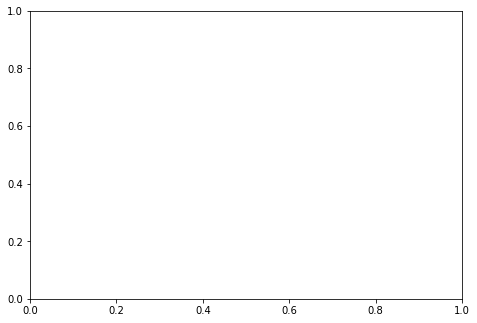

In [31]:
plot_barplot(results, test='num_genomes', metric='classification')
plot_barplot(results, test='num_genomes', metric='abundance')

results['num_genomes']

### Number of read mutations

In [ ]:
plot_barplot(results, test='num_reads_200genomes', metric='classification')
plot_barplot(results, test='num_reads_200genomes', metric='abundance')

### Number of reads

In [ ]:
plot_barplot(results, test='num_reads_800genomes', metric='classification')
plot_barplot(results, test='num_reads_800genomes', metric='abundance')

In [6]:
!pwd

/gpfs/summit/scratch/dral3008/BENCHMARKING_RESULTS/src/benchmarking
